---
title: "Lab 6"
format:
  html:
    embed-resources: true
    code-fold: true
execute:
  echo: true
  warning: false
  message: false
---

# **Part 0 : Loading, cleaning, and Preparing the Data**

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


In [2]:
hitters = pd.read_csv("/content/Hitters.csv")
hitters.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
# It looks like salary has at least one missing value and since that is what we are trying to predict (our y)
# I feel like it makes the most sense to drop rows with salary not filled in the dataset
hitters_cleaned = hitters.dropna(subset=['Salary'])
print(hitters.shape)
print(hitters_cleaned.shape)

(322, 20)
(263, 20)


So yeah it looks like we actually removed almost 60 rows because of this, kind of a lot but an important thing to do

# **Part 1 : Different Model Specs**

**A. Regression without regularization**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [4]:
# PART 1
# Identifying our main variables -- for X we are just keeping everything excpet for salary
X = hitters_cleaned.drop('Salary', axis=1)
y = hitters_cleaned['Salary']

# This was a cool trick that I searched up where I could identify if each was numeric
# or categorical, then based on that put it into my column transformed
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Creating the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]) #Dummy variables made

# Applying into pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

# Now fitting it on the whole dataset
model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [5]:
# PART 2 -- getting some of the coefficients
# Get the fitted linear regression model from the pipeline
# I asked for a little ai support at the start for this because I was getting confused how to pull them correctly
linear_regressor = model.named_steps['regressor']
preprocessor_fitted = model.named_steps['preprocessor']
feature_names_out = preprocessor_fitted.get_feature_names_out()

# I thought this would be nice in a table because otherwise it's hard to know what you are pulling from
coefficients = pd.DataFrame({'varable (including dummy)': feature_names_out, 'coefficient': linear_regressor.coef_})
print("Model Coefficients:")
print(coefficients)


Model Coefficients:
   varable (including dummy)  coefficient
0                 num__AtBat  -291.094556
1                  num__Hits   337.830479
2                 num__HmRun    37.853837
3                  num__Runs   -60.572479
4                   num__RBI   -26.994984
5                 num__Walks   135.073897
6                 num__Years   -16.693359
7                num__CAtBat  -391.038655
8                 num__CHits    86.687617
9                num__CHmRun   -14.181723
10                num__CRuns   480.747135
11                 num__CRBI   260.689886
12               num__CWalks  -213.892259
13              num__PutOuts    78.761296
14              num__Assists    53.732490
15               num__Errors   -22.160862
16             cat__League_A   -31.299712
17             cat__League_N    31.299712
18           cat__Division_E    58.424623
19           cat__Division_W   -58.424623
20          cat__NewLeague_A    12.381163
21          cat__NewLeague_N   -12.381163


Some intresting coefficinets here, number of hits and number of runs (in career) with the highest positive coefficients which makes total sese. At first I was confused why number of at bats would be negaitve and so strongly negaitve since I figured the more at bats, the more you are in the lineup and likely better, but since there is not a variable for failing at bat (being out) this likely captures some of that.

I was suprised that Years was negaitve. And it was intresting to see that the American league had a neagtive coefficient, then a positve with the new league, but there are likely many hidden factors I am not seeing that are influencing this

True interpretations are as fallows (since we standarzied the quantitaitve variables we need to consider that) :


Num_AtBats : For every 1 standard deciation increase in the number of times at bat in 1986, the player's salary is expected to decrease y by 291, aka about $291,000, holding the other variables constant

cat_NetLeague_A (which I probably shoudl of just taken out one to be reference, but this can work too) :

Holding all other variabkes constant , the American League have predicted salaries abotu $ 24,760 higher than those in the National League on Average (difference between these two coefficents is about 24.76, double the individual coefficient) -- probably should of just made one the reference but as long as I keep this in mind it should be fine and work

In [6]:
# PART 3 --  Performing cross-validation
mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
average_mse = mse_scores.mean()
print(f" Average Cross-Validation MSE: {average_mse}")

 Average Cross-Validation MSE: 121136.31031816886


**B. Ridge regression**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the
 hyperparameter.

3. Fit the pipeline with your chosen
 to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np

#PART 1 --
# We already did the set up for it, now we just have to change it to ridge model
ridge_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', Ridge())])



Quick note below, I refer to them as alpha but I am aware this is the lambda value, when I researched it up it seemed like titling it alpha is better for the model to read? Going to fallow up on this in class

In [8]:
# PART 2

# Defining the lambda values to go through -- as advised, going through the different log values
param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# This grid search is a newer concept, but based on teacher and AI help I think this is the correct way to use it
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)
best_alpha = grid_search.best_params_['regressor__alpha']
print(" This seems to be the best lambda value :", best_alpha)

 This seems to be the best lambda value : 1


In [9]:
# PART 3
# Now applying that lamda we found
tuned_ridge_model = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', Ridge(alpha=best_alpha))])
tuned_ridge_model.fit(X, y)

# Again same steps on 1, got some AI help to display this nicely but this is the MAIN
# thing AI helped me with in this one
ridge_regressor = tuned_ridge_model.named_steps['regressor']
feature_names_out = tuned_ridge_model.named_steps['preprocessor'].get_feature_names_out()
coefficients = pd.DataFrame({'feature': feature_names_out, 'coefficient': ridge_regressor.coef_})
print("\nTuned Ridge Model Coefficients:")
print(coefficients)


Tuned Ridge Model Coefficients:
             feature  coefficient
0         num__AtBat  -270.686441
1          num__Hits   296.645050
2         num__HmRun    18.100592
3          num__Runs   -29.339406
4           num__RBI    -9.113295
5         num__Walks   124.407173
6         num__Years   -38.667748
7        num__CAtBat  -225.406548
8         num__CHits   126.659607
9        num__CHmRun    39.070924
10        num__CRuns   320.412169
11         num__CRBI   160.386784
12       num__CWalks  -184.423611
13      num__PutOuts    78.623656
14      num__Assists    47.462597
15       num__Errors   -23.724190
16     cat__League_A   -30.438855
17     cat__League_N    30.438855
18   cat__Division_E    60.015595
19   cat__Division_W   -60.015595
20  cat__NewLeague_A    13.111282
21  cat__NewLeague_N   -13.111282


Num_AtBats : For every 1 standard deviation increase in the number of times at bat in 1986, the player's salary is expected to decrease y by about 270, aka $270,000, holding the other variables constant

Num_Hits : For every 1 standard deviation increase in the number of hits in 1986, the player's salary is expected to increase y about $296,000, holding the other variables constant

num__CRuns : For every 1 standard deviation increase in the number of career runs, the player's salary is expected to increase y about $126,000, holding the other variables constant

Note to make, most of these coefficients seem a to be smaller than in PArt A -- there is a couple categorical outliers, but otherwise it seems that all get smaller

In [10]:
# PART 4 --  Performing cross-validation
mse_scores_ridge = -cross_val_score(tuned_ridge_model, X, y, scoring='neg_mean_squared_error', cv=5)
average_mse_ridge = mse_scores_ridge.mean()
print("Average Cross-Validation MSE for Tuned Ridge Model:", average_mse_ridge)

Average Cross-Validation MSE for Tuned Ridge Model: 119144.43267691585


This is smaller than our answer in Part A!

**C. Lasso Regression**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the
 hyperparameter.

3. Fit the pipeline with your chosen
 to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [11]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import numpy as np

# PART 1
#  Aagin, already created it, now we just need to apply Lasso to it
lasso_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', Lasso(max_iter=10000))]) # Set this inter_max as it seemed the best practice



In [38]:
# PART 2
# Same as the last time in what we are doing
param_grid_lasso = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search_lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X, y)

best_alpha_lasso = grid_search_lasso.best_params_['regressor__alpha']
print(f"Best lambda found for Lasso: {best_alpha_lasso}")



Best lambda found for Lasso: 1


In [13]:
# 6.Now just applying it and finding those important values again
tuned_lasso_model = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', Lasso(alpha=best_alpha_lasso, max_iter=10000))])
tuned_lasso_model.fit(X, y)

# Again I liked the naming help I orginally got from ai, so applying this sampel principle here
lasso_regressor = tuned_lasso_model.named_steps['regressor']
feature_names_out_lasso = tuned_lasso_model.named_steps['preprocessor'].get_feature_names_out()

# A nice output
coefficients_lasso = pd.DataFrame({'feature': feature_names_out_lasso, 'coefficient': lasso_regressor.coef_})

#  I was trying to get rid of scneitific notation because it was harder to interpret
pd.options.display.float_format = '{:.4f}'.format

print("Tuned Lasso Model Coefficients:")
print(coefficients_lasso)

# Reset pandas display option to default  -- ai told me to do this to keep colab congruent
pd.options.display.float_format = None

Tuned Lasso Model Coefficients:
             feature  coefficient
0         num__AtBat    -282.3696
1          num__Hits     304.3583
2         num__HmRun      11.1271
3          num__Runs     -24.9660
4           num__RBI      -0.0000
5         num__Walks     120.6948
6         num__Years     -34.9475
7        num__CAtBat    -162.6441
8         num__CHits       0.0000
9        num__CHmRun      14.2229
10        num__CRuns     375.5650
11         num__CRBI     192.6164
12       num__CWalks    -189.6431
13      num__PutOuts      78.7603
14      num__Assists      41.9967
15       num__Errors     -18.4794
16     cat__League_A     -35.8261
17     cat__League_N       0.0000
18   cat__Division_E     114.4130
19   cat__Division_W      -0.0000
20  cat__NewLeague_A       0.0000
21  cat__NewLeague_N      -0.0000



Num_Hits : For every 1 standard deviation increase in the number of hits in 1986, the player's salary is expected to increase y about $304,000, holding the other variables constant

num__CRuns : For every 1 standard deviation increase in the number of career runs, the player's salary is expected to increase y about $375,000, holding the other variables constant

NOTE : This num_CRUns just had a HUGE jump in it's coefficient, going from 126 -> 375. Intresting how much values can change from the ridge to lasso method

In [14]:

# PART 4 -- same coding principles as in last couple questions
mse_scores_lasso = -cross_val_score(tuned_lasso_model, X, y, scoring='neg_mean_squared_error', cv=5)
average_mse_lasso = mse_scores_lasso.mean()
print(f"\nAverage Cross-Validation MSE for Tuned Lasso Model: {average_mse_lasso}")


Average Cross-Validation MSE for Tuned Lasso Model: 119758.2278152887


SLIGHLTY larger value that PART C

**D. Elastic Net**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the
 and
 hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [15]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import numpy as np

# STEP 1 -- still buidling of that first model, now again just putting Elastic Net in the right spot
elastic_net_model = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', ElasticNet(max_iter=10000))])


In [16]:

# STEP 2 -- setting it up like before, but now tuning both lambda and alpha
param_grid_elastic_net = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}


grid_search_elastic_net = GridSearchCV(elastic_net_model, param_grid_elastic_net, cv=5, scoring='neg_mean_squared_error')
grid_search_elastic_net.fit(X, y)

# 5. Get the best alpha and l1_ratio from the fitted GridSearchCV object and print them.
best_alpha_elastic_net = grid_search_elastic_net.best_params_['regressor__alpha']
best_l1_ratio_elastic_net = grid_search_elastic_net.best_params_['regressor__l1_ratio']
print(f"Best lambda found for Elastic Net: {best_alpha_elastic_net}")
print(f"Best alpha found for Elastic Net: {best_l1_ratio_elastic_net}")

Best lambda found for Elastic Net: 0.1
Best alpha found for Elastic Net: 0.9


In [17]:
# 6. Create a new pipeline with the best alpha and l1_ratio found and fit it to the entire dataset.
tuned_elastic_net_model = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', ElasticNet(alpha=best_alpha_elastic_net, l1_ratio=best_l1_ratio_elastic_net, max_iter=10000))])
tuned_elastic_net_model.fit(X, y)

# 7. Extract the fitted ElasticNet regressor from the tuned pipeline.
elastic_net_regressor = tuned_elastic_net_model.named_steps['regressor']

# 8. Get the feature names after preprocessing from the tuned pipeline.
feature_names_out_elastic_net = tuned_elastic_net_model.named_steps['preprocessor'].get_feature_names_out()

# 9. Create a pandas DataFrame to display the feature names and their corresponding coefficients from the fitted ElasticNet model and print it.
coefficients_elastic_net = pd.DataFrame({'feature': feature_names_out_elastic_net, 'coefficient': elastic_net_regressor.coef_})
print("\nTuned Elastic Net Model Coefficients:")
display(coefficients_elastic_net)


Tuned Elastic Net Model Coefficients:


,feature,coefficient
0,num__AtBat,-231.507759
1,num__Hits,247.556168
2,num__HmRun,4.470970
3,num__Runs,-5.041710
4,num__RBI,2.384300
5,num__Walks,110.808219
6,num__Years,-49.541493
7,num__CAtBat,-115.294004
8,num__CHits,120.015087
9,num__CHmRun,55.914795


Very intresring the changes made from Part B and C

Num_AtBats : For every 1 standard deviation increase in the number of times at bat in 1986, the player's salary is expected to decrease y by 225, aka about $225,000, holding the other variables constant


Num_CWalks : For every 1 standard deviation increase in the number of career walks, the player's salary is expected to decrease y by 151, aka about $151,000, holding the other variables constant -- it is crazy to me how high this value is! I remind myself how much 1 standard deviation increase can be!


Num_Assists : For every 1 standard deviation increase in the number of assists in 1986, the player's salary is expected to increase y by 40, aka about $40,000, holding the other variables constant

In [18]:
#STEP 4 : FInding the MSE again -- this seemed to be the best way to do  it
mse_scores_elastic_net = -cross_val_score(tuned_elastic_net_model, X, y, scoring='neg_mean_squared_error', cv=5)
average_mse_elastic_net = mse_scores_elastic_net.mean()

print("Average Cross-Validation MSE for Tuned Elastic Net Model: ", average_mse_elastic_net)

Average Cross-Validation MSE for Tuned Elastic Net Model:  118969.49145597247


Smallest MSE yet!

# **Part II. Variable Selection**

Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important

Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: lambda and alpha must be re-tuned for each feature set.)

I looked back through the lab to see what coefficients had the highest avsolute value for each, then from there estiated which was the best numeric and categorical variable

* Based on the results throughout this lab, it looks like the most important numeric variable is Career Runs
* Based on the results throughout this lab, it looks like the 5 most important numeric variabels are num_CRuns, num_hits, num_AtBat, num_CAtBat, and numCRIB
* The most important catgeorical variable seems to be the division (East or West)


In [20]:
#Defining these feature's in their own assigned names
feature_set_1 = ['CRuns']

feature_set_2 = ['CRuns', 'Hits', 'AtBat', 'CAtBat', 'CWalks']

# Create a new DataFrame toadd all of the interactions for feature_set_3
X_interactions = X.copy()

# Finally creating  a dummy variable for one level of Division , likely should have dont this ahwile ago
# but by dropping the first category, 'Division_E' becomes the base
division_dummy = pd.get_dummies(X_interactions['Division'], prefix='Division', drop_first=True)

# Add the dummy variable to X_interactions
X_interactions = pd.concat([X_interactions, division_dummy], axis=1)

# Generate interaction terms for each of the five most important numeric variables with the single 'Division_W' dummy variable
interaction_features = []
for numeric_var in feature_set_2:
    interaction_feature_name = f'{numeric_var}_x_Division_W'
    X_interactions[interaction_feature_name] = X_interactions[numeric_var] * X_interactions['Division_W']
    interaction_features.append(interaction_feature_name)



# feature_set_3 will now include the five numeric variables and their interaction with the 'Division_W' dummy
feature_set_3 = feature_set_2 + interaction_features + ['Division_W']


print("Feature Set 1:", feature_set_1)
print("Feature Set 2:", feature_set_2)
print("Feature Set 3 (numeric + interactions with one dummy):", feature_set_3)

Feature Set 1: ['CRuns']
Feature Set 2: ['CRuns', 'Hits', 'AtBat', 'CAtBat', 'CWalks']
Feature Set 3 (numeric + interactions with one dummy): ['CRuns', 'Hits', 'AtBat', 'CAtBat', 'CWalks', 'CRuns_x_Division_W', 'Hits_x_Division_W', 'AtBat_x_Division_W', 'CAtBat_x_Division_W', 'CWalks_x_Division_W', 'Division_W']


In [21]:
# Making a results dictionary to store the results
results = {}

# Defining the models to use
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=10000),
    'ElasticNet': ElasticNet(max_iter=10000)
}

# Defining the feature sets
feature_sets = {
    'feature_set_1': feature_set_1,
    'feature_set_2': feature_set_2,
    'feature_set_3': feature_set_3
}



This next step is where I used some AI support, I wrote the function to begin with bu needed AI help to work out some of the kinks and made it run much more soundly

This is where I foudn ai support to be extremely helpful as I am not the best with complex functions yet, so this helepd bridge that gap

It was a lot of what I did in part 1, but now just combining it all together

I initially did this all in one code, but got a little too confusing so I made the Linear Regression one then changed it where I saw fit for the other 3

In [31]:
# Process Linear Regression with all feature sets

model_name = 'LinearRegression'
model_instance = models[model_name]

# this was ai's idea to keep seeing what was being loaded
print(f"Processing {model_name} with all feature sets...")

for feature_set_name, feature_set_columns in feature_sets.items():
    print(f"  Processing {model_name} with {feature_set_name}...")

    # Selectisg the appropriate DataFrame and columns
    if feature_set_name in ['feature_set_1', 'feature_set_2']:
        X_subset = X[feature_set_columns]
    else: # feature_set_3
        X_subset = X_interactions[feature_set_columns]

    # This was kind of a complicated pre processor, but seemed like the best way to do it after some trial and error
    numeric_features_subset = X_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_subset.select_dtypes(include=['object']).columns

    if feature_set_name == 'feature_set_3' and 'Division_W' in X_subset.columns:
         numeric_features_subset = numeric_features_subset.tolist() + ['Division_W']
         categorical_features_subset = categorical_features_subset.tolist()

    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', StandardScaler(), numeric_features_subset))
    if len(categorical_features_subset) > 0:
         transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_subset))

    preprocessor_subset = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Create a Pipeline same as before
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_subset),
                               ('regressor', model_instance)])

    # Evaluating in the same way before
    mse_scores = -cross_val_score(pipeline, X_subset, y, scoring='neg_mean_squared_error', cv=5)
    average_mse = mse_scores.mean()
    results[f'{model_name}_{feature_set_name}'] = average_mse

    print(f"    Completed {model_name} with {feature_set_name}. Average MSE: {average_mse}")

print(f"\nFinished processing {model_name}.")

Processing LinearRegression with all feature sets...
  Processing LinearRegression with feature_set_1...
    Completed LinearRegression with feature_set_1. Average MSE: 143812.9359162973
  Processing LinearRegression with feature_set_2...
    Completed LinearRegression with feature_set_2. Average MSE: 127649.37020397613
  Processing LinearRegression with feature_set_3...
    Completed LinearRegression with feature_set_3. Average MSE: 132104.08771759557

Finished processing LinearRegression.


Ridge regression

Time to look at ridge regression with all the same features, this time I also had to look at lambda (which I often refer to as alpha as this seems like the way most coding people do it?)

In [37]:
# Look to code above on choices

model_name = 'Ridge'
model_instance = models[model_name]

print(f"\nProcessing {model_name} with all feature sets...")

for feature_set_name, feature_set_columns in feature_sets.items():
    print(f"  Processing {model_name} with {feature_set_name}...")

    # Select the appropriate DataFrame and columns
    if feature_set_name in ['feature_set_1', 'feature_set_2']:
        X_subset = X[feature_set_columns]
    else: # feature_set_3
        X_subset = X_interactions[feature_set_columns]

    # Create a preprocessor
    numeric_features_subset = X_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_subset.select_dtypes(include=['object']).columns

    if feature_set_name == 'feature_set_3' and 'Division_W' in X_subset.columns:
         numeric_features_subset = numeric_features_subset.tolist() + ['Division_W']
         categorical_features_subset = categorical_features_subset.tolist()

    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', StandardScaler(), numeric_features_subset))
    if len(categorical_features_subset) > 0:
         transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_subset))

    preprocessor_subset = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Create a Pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_subset),
                               ('regressor', model_instance)])

    # Tuing the same way as before
    param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_subset, y)
    best_params = grid_search.best_params_
    best_alpha = best_params['regressor__alpha']
    print(f"    Best lambda found for {model_name} with {feature_set_name}: {best_alpha}")


    tuned_model_instance = models[model_name].set_params(**best_params.get('regressor', {}))
    tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor_subset),
                                      ('regressor', tuned_model_instance)])

    mse_scores = -cross_val_score(tuned_pipeline, X_subset, y, scoring='neg_mean_squared_error', cv=5)
    average_mse = mse_scores.mean()
    results[f'{model_name}_{feature_set_name}'] = average_mse

    print(f"    Completed {model_name} with {feature_set_name}. AVerage MSE: {average_mse}")

print(f"\nFinished processing {model_name}.")


Processing Ridge with all feature sets...
  Processing Ridge with feature_set_1...
    Best lambda found for Ridge with feature_set_1: 10
    Completed Ridge with feature_set_1. AVerage MSE: 143783.7068541863
  Processing Ridge with feature_set_2...
    Best lambda found for Ridge with feature_set_2: 1
    Completed Ridge with feature_set_2. AVerage MSE: 126800.37050367217
  Processing Ridge with feature_set_3...
    Best lambda found for Ridge with feature_set_3: 100
    Completed Ridge with feature_set_3. AVerage MSE: 130152.6180215665

Finished processing Ridge.


Lasso regression

In [36]:
# Process Lasso Regression with all feature sets

model_name = 'Lasso'
model_instance = models[model_name]

print(f"\nProcessing {model_name} with all feature sets...")

for feature_set_name, feature_set_columns in feature_sets.items():
    print(f"  Processing {model_name} with {feature_set_name}...")

    # Select the appropriate DataFrame and columns
    if feature_set_name in ['feature_set_1', 'feature_set_2']:
        X_subset = X[feature_set_columns]
    else: # feature_set_3
        X_subset = X_interactions[feature_set_columns]

    # Create a preprocessor
    numeric_features_subset = X_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_subset.select_dtypes(include=['object']).columns

    if feature_set_name == 'feature_set_3' and 'Division_W' in X_subset.columns:
         numeric_features_subset = numeric_features_subset.tolist() + ['Division_W']
         categorical_features_subset = categorical_features_subset.tolist()

    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', StandardScaler(), numeric_features_subset))
    if len(categorical_features_subset) > 0:
         transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_subset))

    preprocessor_subset = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Create a Pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_subset),
                               ('regressor', model_instance)])

    # Tune and Evaluate
    param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_subset, y)
    best_params = grid_search.best_params_
    best_alpha = best_params['regressor__alpha']
    print(f"    Best lambda found for {model_name} with {feature_set_name}: {best_alpha}")

    tuned_model_instance = models[model_name].set_params(**best_params.get('regressor', {}))
    tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor_subset),
                                      ('regressor', tuned_model_instance)])

    mse_scores = -cross_val_score(tuned_pipeline, X_subset, y, scoring='neg_mean_squared_error', cv=5)
    average_mse = mse_scores.mean()
    results[f'{model_name}_{feature_set_name}'] = average_mse

    print(f"    Completed {model_name} with {feature_set_name}. AVerage  MSE: {average_mse}")

print(f"\nFinished processing {model_name}.")


Processing Lasso with all feature sets...
  Processing Lasso with feature_set_1...
    Best lambda found for Lasso with feature_set_1: 10
    Completed Lasso with feature_set_1. AVerage  MSE: 143801.6060840633
  Processing Lasso with feature_set_2...
    Best lambda found for Lasso with feature_set_2: 1
    Completed Lasso with feature_set_2. AVerage  MSE: 127187.74346481934
  Processing Lasso with feature_set_3...
    Best lambda found for Lasso with feature_set_3: 10
    Completed Lasso with feature_set_3. AVerage  MSE: 130480.5119433542

Finished processing Lasso.


Elastic Net version

In [35]:
# Process Elastic Net with all feature sets

model_name = 'ElasticNet'
model_instance = models[model_name]

print(f"\nProcessing {model_name} with all feature sets...")

for feature_set_name, feature_set_columns in feature_sets.items():
    print(f"  Processing {model_name} with {feature_set_name}...")

    # Select the appropriate DataFrame and columns
    if feature_set_name in ['feature_set_1', 'feature_set_2']:
        X_subset = X[feature_set_columns]
    else: # feature_set_3
        X_subset = X_interactions[feature_set_3]

    # Create a preprocessor
    numeric_features_subset = X_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_subset.select_dtypes(include=['object']).columns

    if feature_set_name == 'feature_set_3' and 'Division_W' in X_subset.columns:
         numeric_features_subset = numeric_features_subset.tolist() + ['Division_W']
         categorical_features_subset = categorical_features_subset.tolist()

    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', StandardScaler(), numeric_features_subset))
    if len(categorical_features_subset) > 0:
         transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_subset))

    preprocessor_subset = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Create a Pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor_subset),
                               ('regressor', model_instance)])

    # Tune and Evaluate
    param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'regressor__l1_ratio': [0.1, 0.5, 0.9]}
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_subset, y)
    best_params = grid_search.best_params_
    best_alpha = best_params['regressor__alpha']
    best_l1_ratio = best_params['regressor__l1_ratio']
    print(f"    Best lambda found for {model_name} with {feature_set_name}: {best_alpha}")
    print(f"    Best alpha found for {model_name} with {feature_set_name}: {best_l1_ratio}")

    tuned_model_instance = models[model_name].set_params(**best_params.get('regressor', {}))
    tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor_subset),
                                      ('regressor', tuned_model_instance)])

    mse_scores = -cross_val_score(tuned_pipeline, X_subset, y, scoring='neg_mean_squared_error', cv=5)
    average_mse = mse_scores.mean()
    results[f'{model_name}_{feature_set_name}'] = average_mse

    print(f"    Completed {model_name} with {feature_set_name}. Average MSE: {average_mse}")

print(f"\nFinished processing {model_name}.")


Processing ElasticNet with all feature sets...
  Processing ElasticNet with feature_set_1...
    Best lambda found for ElasticNet with feature_set_1: 0.1
    Best alpha found for ElasticNet with feature_set_1: 0.5
    Completed ElasticNet with feature_set_1. Average MSE: 149274.9942766509
  Processing ElasticNet with feature_set_2...
    Best lambda found for ElasticNet with feature_set_2: 0.01
    Best alpha found for ElasticNet with feature_set_2: 0.1
    Completed ElasticNet with feature_set_2. Average MSE: 131336.03247013883
  Processing ElasticNet with feature_set_3...
    Best lambda found for ElasticNet with feature_set_3: 1
    Best alpha found for ElasticNet with feature_set_3: 0.9
    Completed ElasticNet with feature_set_3. Average MSE: 127245.65511146995

Finished processing ElasticNet.


Among all of the models, it looks like Ridge Regreesion with Feature Set 2 achieved the lowest cross validation average MSE of 126,800!

This makes sense because ridge stablizes coefficiences and estimates to often get a lower MSE.

The second was elastic Net which was also very close to beating it

# **Part III. Discussion**

**A. Ridge**

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

The ridge coefficients were almost always smaller than the ordinary regression models, but seemed to always point in the same way as in the sign was the same(negaitve and positive). I think that is because Ridge adds a penalsity that discourages large coefficiencts, watching out for when predictors are correlated, whcih they defintely are in a dataset like this. The l squared value in the formal equation seems to be the main source of change, with the ridge model producing smaller coeficients, but also reduced variable and what seems like better out-of-sample performacne

**B. LASSO**

Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda
 results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

* Lasso modle from part 1 :

Average Cross-Validation MSE for Tuned Lasso Model: 119758.2278152887

Best lambda found for Lasso: 1


* Lasso model's from part 2 :

 feature_set_1...

    Best lambda found for Lasso with feature_set_1: 10
    Completed Lasso with feature_set_1. AVerage  MSE: 143801.6060840633

  Processing Lasso with feature_set_2*...

    Best lambda found for Lasso with feature_set_2: 1
    Completed Lasso with feature_set_2. AVerage  MSE: 127187.74346481934

  Processing Lasso with feature_set_3...

    Best lambda found for Lasso with feature_set_3: 10
    Completed Lasso with feature_set_3. AVerage  MSE: 130480.5119433542

WHen comparing parrt 1 and 2, the lambda's were not the same, with part 1 having 1 as the best lambda, while part 2 had 10,1, and 10. Although not exactlty thr same, they are pretty similar and honestly a lot more similar than a lot of the other models which had more variation. .

THE MSE's were pretty similar across all four of these model's, only ranging from 119758 to 143801, which is a lot, bit given this dataset it is somewhat consistent.

Both of these things make sense because Lasso has a built in feature selection so even when we had all those variables, it probably had a large empahsis on the variables we ended up keeping later. Where Ridge doesn't have variable selection naturally, so when we added variable selection it made a lot more changes than lasso which naturally incooperated a lot of this

This is a big plus of Lasso, it can take a variable heavy dataset and naturally select some of the most important, which then like I said when we then pulled it by hand and gave it specifc variavles it gives similar lambda and MSE results since in a way it was already done that (just in not as severe of a way)! A vert useful model in some cases

**C. Elastic Net**

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Although I woudln't say that the Elastic Net ALWAYS wins, it does seem to do a very very good job because it is a nice combonoation between Ridge and Lasso. It uses Ridges ability to stablize coefficient and handle correlated predictors, while also using Lassos ability to to feature selection and simplifying the model. When combined, it balences the two effects and creates a very powerful model.

It can retain groups of correlated variables rather than totally just dropping one (like LASSO sometimes) while not being quite as overly complex as Ridge. This seems like the best overall model to use, though it can be beaten out depedning on the specfic data!

# **Part IV: Final Model**

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

Best lambda for the final Ridge model with Feature Set 2: 1
Best Model: Ridge Regression
Best Feature Set: ['CRuns', 'Hits', 'AtBat', 'CAtBat', 'CWalks']
Tuned Alpha: 1.0000
Estimated Out-of-Sample MSE (from cross-validation): 119144.43


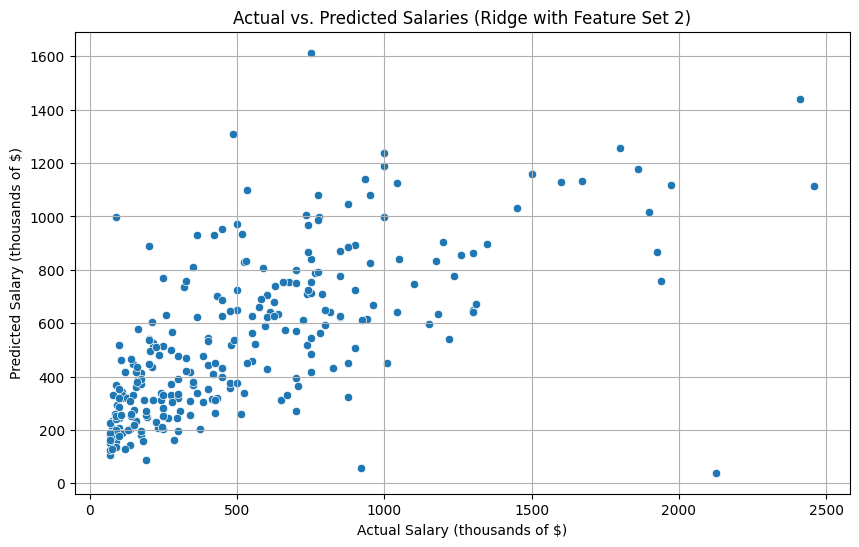

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Copying and pasting what I did for set 2 for the ridge model, what seemed to be the best
best_feature_set = ['CRuns', 'Hits', 'AtBat', 'CAtBat', 'CWalks']


X_best = X[best_feature_set]


numeric_features_best = X_best.select_dtypes(include=['int64', 'float64']).columns
categorical_features_best = X_best.select_dtypes(include=['object']).columns

transformers_best = []
if len(numeric_features_best) > 0:
    transformers_best.append(('num', StandardScaler(), numeric_features_best))
if len(categorical_features_best) > 0:
     transformers_best.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_best))

preprocessor_best = ColumnTransformer(transformers=transformers_best, remainder='passthrough')

pipeline_for_tuning = Pipeline(steps=[('preprocessor', preprocessor_best),
                                       ('regressor', Ridge())])

# Tune
param_grid_ridge = {'regressor__alpha':  [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search_ridge_best = GridSearchCV(pipeline_for_tuning, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge_best.fit(X_best, y)
best_alpha_final = grid_search_ridge_best.best_params_['regressor__alpha']
print(f"Best lambda for the final Ridge model with Feature Set 2: {best_alpha_final}")


#  pipeline
final_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor_best),
                                       ('regressor', Ridge(alpha=best_alpha_final))])

# Fit the final best pipeline on the full cleaned dataset
final_best_pipeline.fit(X_best, y)

# Make predictions using the final model
y_pred = final_best_pipeline.predict(X_best)

# 8. Summarize results and generate a plot

print(f"Best Model: Ridge Regression")
print(f"Best Feature Set: {best_feature_set}")
print(f"Tuned Alpha: {best_alpha_final:.4f}")
print(f"Estimated Out-of-Sample MSE (from cross-validation): {average_mse_ridge:.2f}") # Using the MSE from the previous evaluation for this feature set


# Plotting predicted vs. actual salaries
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred)
plt.xlabel("Actual Salary (thousands of $)")
plt.ylabel("Predicted Salary (thousands of $)")
plt.title("Actual vs. Predicted Salaries (Ridge with Feature Set 2)")
plt.grid(True)
plt.show()

Based on the cross validation results, the Ridge Regression model usingg Feature 2 acheived the lowest average MSE of aroound 126,800 therefore it was selected as the final set, slightly beating out the Elastic Net! I think ridge regresion was ideal for this dataset because there was so many high correlated predicts like runs, RBIs, hits, etc. so the penalty helepd stablize these relationships by strinking the coefficent.

THe final ridge model, then fit on the entire dataset if actual vs predict, shows it actually doing a pretty good job. It is generally 45 degrees which shows strong predictive performance, and a good MSE. There is a few outliers but nothing too crazy(except that one at x=2200 but I think any model would have trouble with that) so it was an impressive model overall.

Overall, the ridge regression model did a great job at providing a balenced and stable model that seems to generalize the data pretty well! Though in a lot of cases it seems like Elastic Net may be the safer option.